In [1]:
# Date to be predicted
obs_id = 1
date = '2022-11-17'
hour = 16

dir_data = '../data'

dir_ckpt = [
#     '../ckpt/1668270620',  # GoodLuckk
    '../ckpt/1667814523',  # Baseline
#     '../ckpt/1668400099',  # GoodLuck with AdamW
#     '../ckpt/1668265483',  # GoodLuck ()
#     '../ckpt/1668432245',  # SE/
]

path_ckpt = list(map(lambda x: f'{x}/last_ckpt.bin', dir_ckpt))

# Training configuration
k = 0.5
features = ['temperature', 'humidity', 'dew_point', 'wind_dir', 'wind_spd',
            'uv_idx', 'visibility', 'ceiling', 'cloudiness', 'precip_prob',
            'precip_1h', 'forecast', 'capacity', 'hour', 'year', 'month', 'day']
input_dim = len(features)
hidden_dim = 10

token = 'YOUR AUTHORIZED TOKEN'

In [2]:
len(features)

17

In [18]:
import sys
sys.path.append('../')

from suncapturer.networks import WaveNet
from suncapturer.utils import Requestor, standardize_time

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime


In [19]:
requestor = Requestor(token)

fcst_ = requestor.get_forecasts(obs_id, date, hour)
fcst_.shape

(72, 13)

In [20]:
fcst = fcst_.copy()
fcst['id'] = 0
fcst['fcst_time'] = pd.to_datetime(fcst['fcst_time'])
fcst['fcst_time'] = fcst['fcst_time'].dt.tz_convert(tz='Asia/Seoul')

fcst['time'] = pd.to_datetime(fcst['time'])
fcst['time'] = fcst['time'].dt.tz_convert(tz='Asia/Seoul')

fcst['fcst_time'] = fcst['fcst_time'].dt.round('60min')
fcst['forecast'] = ((fcst['time'] - fcst['fcst_time']).dt.total_seconds() / 60.0 / 60.0).astype('int')

start = 24 - hour
end = 48 - hour
fcst = fcst[(fcst['forecast'] > start) & (fcst['forecast'] <= end)].reset_index(drop=True)

# 1. Capacity
fcst['capacity'] = 472.39

# 3. Time-related features
fcst['hour']  = fcst['time'].dt.hour
fcst['year']  = fcst['time'].dt.year
fcst['month'] = fcst['time'].dt.month
fcst['day']   = fcst['time'].dt.day

In [21]:
fcst

,fcst_time,time,temperature,humidity,dew_point,wind_dir,wind_spd,uv_idx,visibility,cloudiness,ceiling,precip_prob,precip_1h,id,forecast,capacity,hour,year,month,day
0,2022-11-17 16:00:00+09:00,2022-11-18 01:00:00+09:00,8.88889,87.0,6.66667,235.0,3.70149,0.0,16.0934,0.0,9144.00,0.0,0.0,0,9,472.39,1,2022,11,18
1,2022-11-17 16:00:00+09:00,2022-11-18 02:00:00+09:00,8.33333,86.0,6.11111,236.0,3.70149,0.0,16.0934,0.0,9144.00,0.0,0.0,0,10,472.39,2,2022,11,18
2,2022-11-17 16:00:00+09:00,2022-11-18 03:00:00+09:00,7.77778,84.0,5.00000,235.0,3.70149,0.0,16.0934,0.0,9144.00,0.0,0.0,0,11,472.39,3,2022,11,18
3,2022-11-17 16:00:00+09:00,2022-11-18 04:00:00+09:00,7.22222,83.0,4.44444,232.0,3.70149,0.0,16.0934,28.0,9144.00,0.0,0.0,0,12,472.39,4,2022,11,18
4,2022-11-17 16:00:00+09:00,2022-11-18 05:00:00+09:00,6.66667,83.0,3.88889,226.0,3.70149,0.0,16.0934,56.0,9144.00,0.0,0.0,0,13,472.39,5,2022,11,18
5,2022-11-17 16:00:00+09:00,2022-11-18 06:00:00+09:00,6.11111,82.0,3.33333,219.0,3.70149,0.0,16.0934,84.0,609.60,0.0,0.0,0,14,472.39,6,2022,11,18
6,2022-11-17 16:00:00+09:00,2022-11-18 07:00:00+09:00,7.77778,82.0,5.00000,204.0,3.70149,0.0,16.0934,89.0,640.08,0.0,0.0,0,15,472.39,7,2022,11,18
7,2022-11-17 16:00:00+09:00,2022-11-18 08:00:00+09:00,9.44444,80.0,6.11111,186.0,5.63270,0.0,16.0934,95.0,640.08,0.0,0.0,0,16,472.39,8,2022,11,18
8,2022-11-17 16:00:00+09:00,2022-11-18 09:00:00+09:00,11.11110,76.0,7.22222,182.0,5.63270,0.0,11.2654,100.0,640.08,0.0,0.0,0,17,472.39,9,2022,11,18
9,2022-11-17 16:00:00+09:00,2022-11-18 10:00:00+09:00,12.77780,67.0,7.22222,188.0,5.63270,1.0,16.0934,97.0,640.08,0.0,0.0,0,18,472.39,10,2022,11,18


In [22]:
with open(os.path.join(dir_ckpt[0], 'scaling_factor.pkl'), 'rb') as f:
    import pickle
    scaling_factor = pickle.load(f)

    for col, factors in scaling_factor.items():
        fcst[col] = (fcst[col] - factors[0]) / (factors[1] - factors[0])


In [23]:
fcst

,fcst_time,time,temperature,humidity,dew_point,wind_dir,wind_spd,uv_idx,visibility,cloudiness,ceiling,precip_prob,precip_1h,id,forecast,capacity,hour,year,month,day
0,2022-11-17 16:00:00+09:00,2022-11-18 01:00:00+09:00,0.495145,0.867347,0.716312,0.652778,0.036335,0.000000,0.519612,0.00,0.731696,0.0,0.0,0,0.000000,1.0,0.043478,1.0,0.909091,0.566667
1,2022-11-17 16:00:00+09:00,2022-11-18 02:00:00+09:00,0.485436,0.857143,0.709220,0.655556,0.036335,0.000000,0.519612,0.00,0.731696,0.0,0.0,0,0.043478,1.0,0.086957,1.0,0.909091,0.566667
2,2022-11-17 16:00:00+09:00,2022-11-18 03:00:00+09:00,0.475728,0.836735,0.695035,0.652778,0.036335,0.000000,0.519612,0.00,0.731696,0.0,0.0,0,0.086957,1.0,0.130435,1.0,0.909091,0.566667
3,2022-11-17 16:00:00+09:00,2022-11-18 04:00:00+09:00,0.466019,0.826531,0.687943,0.644444,0.036335,0.000000,0.519612,0.28,0.731696,0.0,0.0,0,0.130435,1.0,0.173913,1.0,0.909091,0.566667
4,2022-11-17 16:00:00+09:00,2022-11-18 05:00:00+09:00,0.456310,0.826531,0.680851,0.627778,0.036335,0.000000,0.519612,0.56,0.731696,0.0,0.0,0,0.173913,1.0,0.217391,1.0,0.909091,0.566667
5,2022-11-17 16:00:00+09:00,2022-11-18 06:00:00+09:00,0.446601,0.816327,0.673759,0.608333,0.036335,0.000000,0.519612,0.84,0.048780,0.0,0.0,0,0.217391,1.0,0.260870,1.0,0.909091,0.566667
6,2022-11-17 16:00:00+09:00,2022-11-18 07:00:00+09:00,0.475728,0.816327,0.695035,0.566667,0.036335,0.000000,0.519612,0.89,0.051219,0.0,0.0,0,0.260870,1.0,0.304348,1.0,0.909091,0.566667
7,2022-11-17 16:00:00+09:00,2022-11-18 08:00:00+09:00,0.504854,0.795918,0.709220,0.516667,0.055292,0.000000,0.519612,0.95,0.051219,0.0,0.0,0,0.304348,1.0,0.347826,1.0,0.909091,0.566667
8,2022-11-17 16:00:00+09:00,2022-11-18 09:00:00+09:00,0.533980,0.755102,0.723404,0.505556,0.055292,0.000000,0.359732,1.00,0.051219,0.0,0.0,0,0.347826,1.0,0.391304,1.0,0.909091,0.566667
9,2022-11-17 16:00:00+09:00,2022-11-18 10:00:00+09:00,0.563107,0.663265,0.723404,0.522222,0.055292,0.083333,0.519612,0.97,0.051219,0.0,0.0,0,0.391304,1.0,0.434783,1.0,0.909091,0.566667


In [29]:
models = []
for i in range(len(dir_ckpt)):
    model = WaveNet(len(features), hidden_dim)
    ckpt  = torch.load(path_ckpt[i])
    model.load_state_dict(ckpt['model_state_dict'])
    models.append(model)

In [30]:
import torch

X_test = fcst.drop(['id', 'fcst_time', 'time'], axis=1)
X_test = X_test[features]
X_test = X_test.values
X_test = torch.from_numpy(X_test).float().unsqueeze(0)
X_test = torch.transpose(X_test, 1, 2)

with torch.no_grad():
    outs = []
    for i in range(len(dir_ckpt)):
        models[i].eval()
        out = models[i](X_test)
        outs.append(out)
    out = torch.stack(outs).mean(dim=0)

    bound = torch.zeros_like(out)
    bound[:, :, 0] = out[:, :, 0] - k * out[:, :, 1]
    bound[:, :, 1] = out[:, :, 0] + k * out[:, :, 1]
    bound = torch.nn.functional.relu(bound)
    bound = bound.detach().squeeze().numpy()
    bound = (472.39 * bound).astype(float)
    bound[np.where(bound < 1.0)] = 0.0

submit = []
for row in bound:
    submit.append({'lower': row[0], 'upper': row[1]})

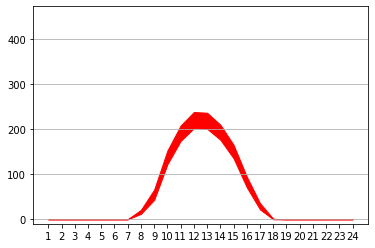

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(bound.mean(axis=1), 'r-', linewidth=0.1)
plt.fill_between(x=np.arange(24), y1=bound[:, 0], y2=bound[:, 1], color='red', alpha=1.0)
plt.grid(axis='y')
plt.ylim(-10, 472.39)
plt.xticks(np.arange(24), np.arange(24) + 1)
plt.show()

In [32]:
submit

[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 12.056658744812012, 'upper': 20.980098724365234},
 {'lower': 43.088104248046875, 'upper': 65.97566223144531},
 {'lower': 122.03980255126953, 'upper': 152.6119384765625},
 {'lower': 173.75958251953125, 'upper': 208.0312957763672},
 {'lower': 202.09759521484375, 'upper': 238.03668212890625},
 {'lower': 200.82142639160156, 'upper': 236.43011474609375},
 {'lower': 176.44284057617188, 'upper': 209.92041015625},
 {'lower': 135.3277130126953, 'upper': 165.28759765625},
 {'lower': 70.89537811279297, 'upper': 94.6568374633789},
 {'lower': 21.83799934387207, 'upper': 35.82499313354492},
 {'lower': 0.0, 'upper': 1.069990634918213},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'up

In [14]:
import requests
import json

success = requests.post(f'https://research-api.dershare.xyz/open-proc/cmpt-2022/bids', data=json.dumps(submit), headers={
                            'Authorization': f'Bearer {token}'
                        }).json()
print(success)

True


In [15]:
print("11월 17일 17시 입찰, [0, 3, 4]")
[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 10.491403579711914, 'upper': 10.491403579711914},
 {'lower': 56.52817916870117, 'upper': 56.52817916870117},
 {'lower': 127.49752807617188, 'upper': 127.49752807617188},
 {'lower': 180.74276733398438, 'upper': 180.74276733398438},
 {'lower': 210.1331024169922, 'upper': 210.1331024169922},
 {'lower': 200.2530059814453, 'upper': 200.2530059814453},
 {'lower': 175.7863311767578, 'upper': 175.7863311767578},
 {'lower': 136.8014373779297, 'upper': 136.8014373779297},
 {'lower': 69.25352478027344, 'upper': 69.25352478027344},
 {'lower': 21.535449981689453, 'upper': 21.535449981689453},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 17일 17시 입찰, [0, 3, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 10.491403579711914, 'upper': 10.491403579711914},
 {'lower': 56.52817916870117, 'upper': 56.52817916870117},
 {'lower': 127.49752807617188, 'upper': 127.49752807617188},
 {'lower': 180.74276733398438, 'upper': 180.74276733398438},
 {'lower': 210.1331024169922, 'upper': 210.1331024169922},
 {'lower': 200.2530059814453, 'upper': 200.2530059814453},
 {'lower': 175.7863311767578, 'upper': 175.7863311767578},
 {'lower': 136.8014373779297, 'upper': 136.8014373779297},
 {'lower': 69.25352478027344, 'upper': 69.25352478027344},
 {'lower': 21.535449981689453, 'upper': 21.535449981689453},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},

In [2]:
print("11월 17일 10시 입찰, [0, 3, 4]")
[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 11.099987983703613, 'upper': 11.099987983703613},
 {'lower': 51.58321762084961, 'upper': 51.58321762084961},
 {'lower': 109.53911590576172, 'upper': 109.53911590576172},
 {'lower': 152.83596801757812, 'upper': 152.83596801757812},
 {'lower': 177.20030212402344, 'upper': 177.20030212402344},
 {'lower': 169.69857788085938, 'upper': 169.69857788085938},
 {'lower': 146.99951171875, 'upper': 146.99951171875},
 {'lower': 110.44286346435547, 'upper': 110.44286346435547},
 {'lower': 64.48393249511719, 'upper': 64.48393249511719},
 {'lower': 24.272037506103516, 'upper': 24.272037506103516},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 17일 10시 입찰, [0, 3, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 11.099987983703613, 'upper': 11.099987983703613},
 {'lower': 51.58321762084961, 'upper': 51.58321762084961},
 {'lower': 109.53911590576172, 'upper': 109.53911590576172},
 {'lower': 152.83596801757812, 'upper': 152.83596801757812},
 {'lower': 177.20030212402344, 'upper': 177.20030212402344},
 {'lower': 169.69857788085938, 'upper': 169.69857788085938},
 {'lower': 146.99951171875, 'upper': 146.99951171875},
 {'lower': 110.44286346435547, 'upper': 110.44286346435547},
 {'lower': 64.48393249511719, 'upper': 64.48393249511719},
 {'lower': 24.272037506103516, 'upper': 24.272037506103516},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0

In [13]:
print("11월 16일 17시 입찰, [0, 3, 4]")
[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 10.213452339172363, 'upper': 10.213452339172363},
 {'lower': 66.65479278564453, 'upper': 66.65479278564453},
 {'lower': 156.61358642578125, 'upper': 156.61358642578125},
 {'lower': 217.31068420410156, 'upper': 217.31068420410156},
 {'lower': 257.632568359375, 'upper': 257.632568359375},
 {'lower': 252.61221313476562, 'upper': 252.61221313476562},
 {'lower': 234.35276794433594, 'upper': 234.35276794433594},
 {'lower': 196.55914306640625, 'upper': 196.55914306640625},
 {'lower': 124.52555084228516, 'upper': 124.52555084228516},
 {'lower': 48.06092071533203, 'upper': 48.06092071533203},
 {'lower': 2.132200241088867, 'upper': 2.132200241088867},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 16일 17시 입찰, [0, 3, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 10.213452339172363, 'upper': 10.213452339172363},
 {'lower': 66.65479278564453, 'upper': 66.65479278564453},
 {'lower': 156.61358642578125, 'upper': 156.61358642578125},
 {'lower': 217.31068420410156, 'upper': 217.31068420410156},
 {'lower': 257.632568359375, 'upper': 257.632568359375},
 {'lower': 252.61221313476562, 'upper': 252.61221313476562},
 {'lower': 234.35276794433594, 'upper': 234.35276794433594},
 {'lower': 196.55914306640625, 'upper': 196.55914306640625},
 {'lower': 124.52555084228516, 'upper': 124.52555084228516},
 {'lower': 48.06092071533203, 'upper': 48.06092071533203},
 {'lower': 2.132200241088867, 'upper': 2.132200241088867},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}

In [1]:
print("11월 16일 10시 입찰, [0, 3, 4]")

[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 18.99832534790039, 'upper': 19.07553482055664},
 {'lower': 79.44874572753906, 'upper': 79.63310241699219},
 {'lower': 176.9337921142578, 'upper': 177.1765594482422},
 {'lower': 241.88873291015625, 'upper': 242.1588592529297},
 {'lower': 278.2548522949219, 'upper': 278.5381774902344},
 {'lower': 276.81683349609375, 'upper': 277.0992431640625},
 {'lower': 254.0624237060547, 'upper': 254.33311462402344},
 {'lower': 215.55223083496094, 'upper': 215.8045196533203},
 {'lower': 144.62362670898438, 'upper': 144.83676147460938},
 {'lower': 67.43359375, 'upper': 67.59113311767578},
 {'lower': 9.56813907623291, 'upper': 9.621768951416016},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 16일 10시 입찰, [0, 3, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 18.99832534790039, 'upper': 19.07553482055664},
 {'lower': 79.44874572753906, 'upper': 79.63310241699219},
 {'lower': 176.9337921142578, 'upper': 177.1765594482422},
 {'lower': 241.88873291015625, 'upper': 242.1588592529297},
 {'lower': 278.2548522949219, 'upper': 278.5381774902344},
 {'lower': 276.81683349609375, 'upper': 277.0992431640625},
 {'lower': 254.0624237060547, 'upper': 254.33311462402344},
 {'lower': 215.55223083496094, 'upper': 215.8045196533203},
 {'lower': 144.62362670898438, 'upper': 144.83676147460938},
 {'lower': 67.43359375, 'upper': 67.59113311767578},
 {'lower': 9.56813907623291, 'upper': 9.621768951416016},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 

In [13]:
print("11월 15일 17시 입찰, [0, 4]")
[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 2.66987943649292, 'upper': 2.66987943649292},
 {'lower': 43.0453987121582, 'upper': 43.0453987121582},
 {'lower': 125.66547393798828, 'upper': 125.66547393798828},
 {'lower': 192.6382293701172, 'upper': 192.6382293701172},
 {'lower': 235.39015197753906, 'upper': 235.39015197753906},
 {'lower': 237.09365844726562, 'upper': 237.09365844726562},
 {'lower': 217.393798828125, 'upper': 217.393798828125},
 {'lower': 178.54493713378906, 'upper': 178.54493713378906},
 {'lower': 114.69747924804688, 'upper': 114.69747924804688},
 {'lower': 45.857177734375, 'upper': 45.857177734375},
 {'lower': 1.4469661712646484, 'upper': 1.4469661712646484},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 15일 17시 입찰, [0, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 2.66987943649292, 'upper': 2.66987943649292},
 {'lower': 43.0453987121582, 'upper': 43.0453987121582},
 {'lower': 125.66547393798828, 'upper': 125.66547393798828},
 {'lower': 192.6382293701172, 'upper': 192.6382293701172},
 {'lower': 235.39015197753906, 'upper': 235.39015197753906},
 {'lower': 237.09365844726562, 'upper': 237.09365844726562},
 {'lower': 217.393798828125, 'upper': 217.393798828125},
 {'lower': 178.54493713378906, 'upper': 178.54493713378906},
 {'lower': 114.69747924804688, 'upper': 114.69747924804688},
 {'lower': 45.857177734375, 'upper': 45.857177734375},
 {'lower': 1.4469661712646484, 'upper': 1.4469661712646484},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower

In [14]:
print("11월 15일 10시 입찰, [0, 3, 4]")
[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 4.055022716522217, 'upper': 4.0901780128479},
 {'lower': 54.70899963378906, 'upper': 54.8679084777832},
 {'lower': 148.5530242919922, 'upper': 148.78143310546875},
 {'lower': 220.42002868652344, 'upper': 220.68145751953125},
 {'lower': 262.562744140625, 'upper': 262.8403015136719},
 {'lower': 265.7515563964844, 'upper': 266.03167724609375},
 {'lower': 244.62098693847656, 'upper': 244.8900604248047},
 {'lower': 204.6072998046875, 'upper': 204.85687255859375},
 {'lower': 132.68771362304688, 'upper': 132.8953094482422},
 {'lower': 55.40205001831055, 'upper': 55.551727294921875},
 {'lower': 4.016962051391602, 'upper': 4.057483196258545},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0}]

11월 15일 10시 입찰, [0, 3, 4]


[{'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 4.055022716522217, 'upper': 4.0901780128479},
 {'lower': 54.70899963378906, 'upper': 54.8679084777832},
 {'lower': 148.5530242919922, 'upper': 148.78143310546875},
 {'lower': 220.42002868652344, 'upper': 220.68145751953125},
 {'lower': 262.562744140625, 'upper': 262.8403015136719},
 {'lower': 265.7515563964844, 'upper': 266.03167724609375},
 {'lower': 244.62098693847656, 'upper': 244.8900604248047},
 {'lower': 204.6072998046875, 'upper': 204.85687255859375},
 {'lower': 132.68771362304688, 'upper': 132.8953094482422},
 {'lower': 55.40205001831055, 'upper': 55.551727294921875},
 {'lower': 4.016962051391602, 'upper': 4.057483196258545},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'lower': 0.0, 'upper': 0.0},
 {'low